In [1]:
%matplotlib notebook

In [2]:
from glob import glob

from tqdm import tqdm 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
import sunpy.visualization.colormaps as cm
from aiapy.calibrate import normalize_exposure, register, update_pointing

In [3]:
def aiaprep(aia_map):
    return normalize_exposure(register(update_pointing(aia_map)))

In [4]:
def to_heliographic(aia_map, shape_out=(720, 1440), observer='earth', center_lat=0, center_lon=0):
    frame_out = SkyCoord(center_lon, center_lat, unit=u.deg,
                         frame="heliographic_carrington",
                         observer=observer,
                         obstime=aia_map.date,
                         rsun=aia_map.coordinate_frame.rsun)
    header = sunpy.map.make_fitswcs_header(shape_out,
                                           frame_out,
                                           scale=(360 / shape_out[1],
                                                  180 / shape_out[0]) * u.deg / u.pix,
                                           projection_code="CAR")
    return aia_map.reproject_to(header)

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [6]:
def scale_map(aia_map, scale=2, nan2zero=True):
    M, N = aia_map.data.shape
    x = np.arange(N)
    y = np.zeros_like(x)
    lon_deg = (aia_map.pixel_to_world(x*u.pix, y*u.pix).lon - aia_map.carrington_longitude).wrap_at('180d').deg
    scale_lon = sigmoid(-np.abs(lon_deg)/scale)
    scale_map = np.ones((M, 1)) @ scale_lon[np.newaxis, :]
    out_map = aia_map * scale_map
    if nan2zero:
        out_map.data[np.isnan(out_map.data)] = 0
    return out_map

In [7]:
def combine_maps(aia_maps):
    dest_data = np.zeros_like(aia_maps[0].data)
    for x in aia_maps:
        dest_data += x.data
    return sunpy.map.Map(dest_data, aia_maps[0].fits_header)

In [8]:
#fits_fnames = ['./data/aia_lev1_193a_2018_12_20t11_48_28_84z_image_lev1.fits',
#               './data/aia_lev1_193a_2018_12_21t11_48_28_84z_image_lev1.fits']

fits_fnames = glob('./data/*.fits')

In [9]:
aia_maps = [sunpy.map.Map(x) for x in tqdm(fits_fnames)]

100%|███████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.83it/s]


In [10]:
aia_level_1_5_maps = [aiaprep(x) for x in tqdm(aia_maps)]
#aia_level_1_5_maps = aia_maps

100%|███████████████████████████████████████████████████████████| 27/27 [02:08<00:00,  4.75s/it]


In [11]:
heliogrpahic_maps = [to_heliographic(x, center_lon=180) for x in tqdm(aia_level_1_5_maps)]

100%|███████████████████████████████████████████████████████████| 27/27 [00:35<00:00,  1.31s/it]


In [12]:
scaled_maps = [scale_map(x, scale=10) for x in tqdm(heliogrpahic_maps)]

100%|███████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.46it/s]


In [13]:
synoptic_map = combine_maps(scaled_maps)

In [14]:
sdoaia193 = plt.get_cmap('sdoaia193')

<IPython.core.display.Javascript object>


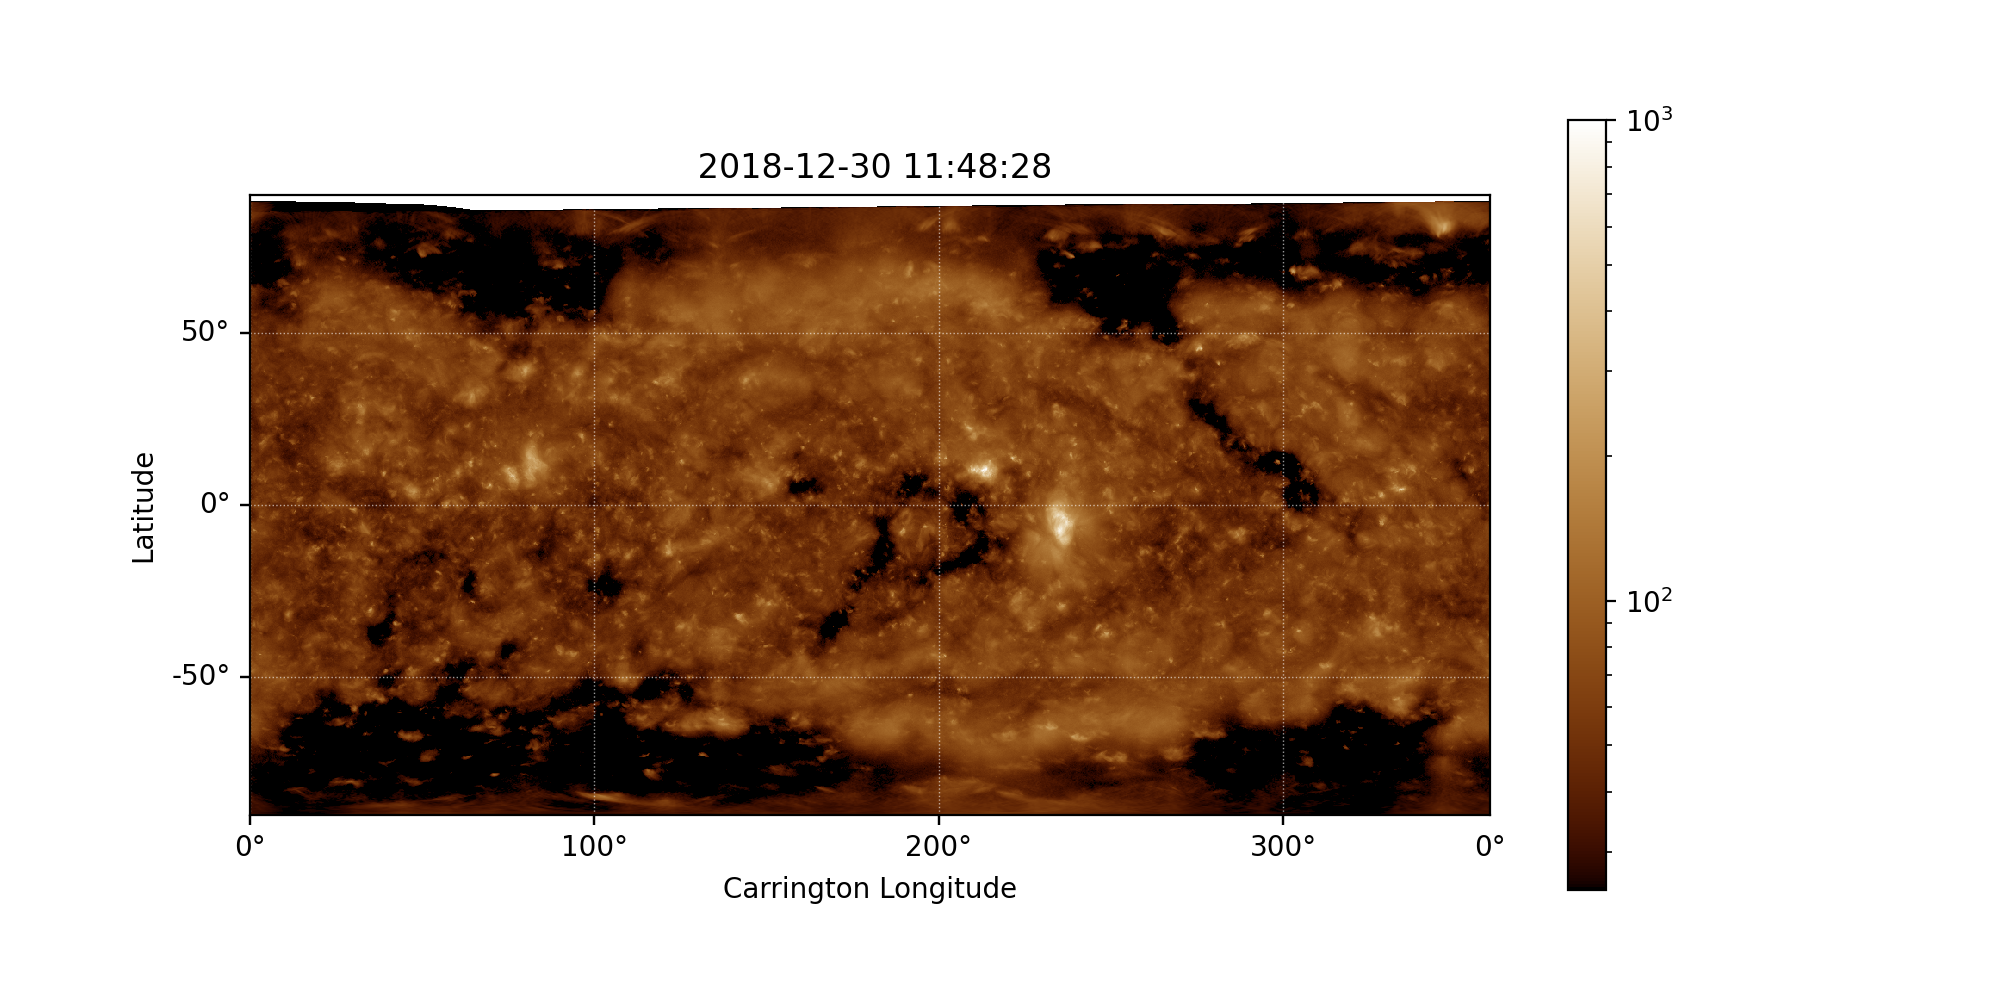

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(projection=synoptic_map)
im = synoptic_map.plot(axes=ax, norm=LogNorm(vmin=25, vmax=1000), cmap=sdoaia193)
lon = ax.coords[0]
lon.set_ticks(spacing=100*u.deg)
lat = ax.coords[1]
lat.set_ticks(spacing=50*u.deg)
fig.colorbar(im)